## Fazendo os imports

In [50]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import plotly.graph_objects as go

# Imports ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf     

# Imports Prophet
from prophet import Prophet

## Extração da base de dados

##### A função extrai de forma incremental, para garantir a atualização correta dos dados

In [51]:
#Variáveis Globais
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

In [52]:
#Função para extrair os dados de forma incremental do site IPEA
def extrai_dados_ipea_incremental(url):
    
    resposta = requests.get(url)

    if resposta.status_code == 200:

        soup = BeautifulSoup(resposta.text, 'html.parser')
        table = soup.find('table', {'id': 'grd_DXMainTable'})

        df_new_data = pd.read_html(str(table), header=0)[0]
        df_new_data.columns = ['data', 'preco_petroleo' ]
        df_new_data['data'] = pd.to_datetime(df_new_data['data'], dayfirst=True)
        df_new_data['preco_petroleo'] = df_new_data['preco_petroleo']/100

        path = 'dados\ipea.csv'

        try:
            df_existente = pd.read_csv(path)
            print(df_existente)
            df_existente['data'] = pd.to_datetime(df_existente['data'], format="%Y-%m-%d")
            

        except FileNotFoundError:
            df_existente = df_new_data
        

        
        #Caso já tenha um arquivo salvo, entende de quando deverá puxar os novos dados
        last_date = df_existente['data'].max()
        new_rows = df_new_data[df_new_data['data'] > last_date]

        if new_rows.empty:
            updated_df = df_existente
        else:
            updated_df = pd.concat([df_existente, new_rows], ignore_index=True)
            
        #Gera o arquivo atualizado
        updated_df.to_csv(path, index=False)
        updated_df.head()

        return updated_df

    else:
        print("Falha ao acessar a página: Status Code", resposta.status_code)


<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_185472\2763138798.py:16: SyntaxWarning: invalid escape sequence '\i'
  path = 'dados\ipea.csv'


In [53]:
updated_df = extrai_dados_ipea_incremental(url)

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_185472\2763138798.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_new_data = pd.read_html(str(table), header=0)[0]


             data  preco_petroleo
0      2024-05-03           83.60
1      2024-05-02           84.81
2      2024-05-01           83.55
3      2024-04-30           88.23
4      2024-04-29           88.44
...           ...             ...
11164  2024-05-13           83.18
11165  2024-05-10           83.39
11166  2024-05-09           83.27
11167  2024-05-08           82.44
11168  2024-05-07           82.69

[11169 rows x 2 columns]


## Overview da série temporal e estudo de milestones

In [54]:
#Criando uma cópia do dataframe para não alterarmos os dados originais
df_eda = updated_df

In [55]:
df_eda.head()

,data,preco_petroleo
0,2024-05-03,83.60
1,2024-05-02,84.81
2,2024-05-01,83.55
3,2024-04-30,88.23
4,2024-04-29,88.44


In [56]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data            11169 non-null  datetime64[ns]
 1   preco_petroleo  11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


In [57]:
#Ordendo através do indice que já está em datetime

df_eda.sort_values(by='data', ascending=True, inplace=True)

#### Visualizando a série temporal

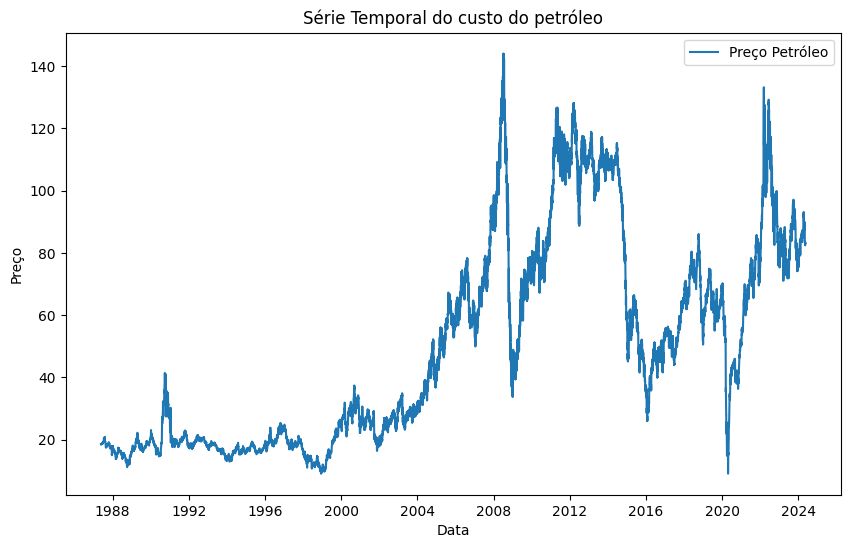

In [58]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df_eda['data'], df_eda['preco_petroleo'], label = 'Preço Petróleo')
plt.title('Série Temporal do custo do petróleo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend(loc='best')
plt.show()

Milestones:

 **1. Pico em 2008:** O preço do petróleo apresentava um aumento contnuo desde 2002. Do fim de 2007 até a metade de 2008, a proporção desse aumento de preço aumentou substancialmente, chgeando a a ultrapassar a barreira de U$140. O aumento escalar da época foi causado por um conjunto de fatores:

    I) Especulação;

    II) Tensões geopolíticas;

    III) Relação entre demanda/oferta. Demanda puxada pelos países emergentes (China e Índia, especialmente.);

    IV) O fato de ser um combustível fóssil não renovável;

    V) Mercado financeiro passava por uma tendência de investimento em matérias primas. 

 **2. Queda abrupta em 2009:** A famosa crise financeira global de 2009 foi a principal responsável pela queda abrupta nos preços dos barris de petróleo. Como os países estavam em recessão, a demanda por petróleo consequentemente diminuiu no período levando junto o seu preço.

 **3. Nova queda abrupta em 2014:** Causada principalmente pelo aumento da oferta, especulação do mercado, fatores políticos e ambientais.

    I) Aumento da oferta: 

        - O EUA investiu em tecnologias inovadoras e aumentou em 40% a sua produção, tornando-se o maior produtor mundial. Os 40% representavam 4milhões de barris de ptróleo por dia, que equivaliam à produção conjunta da Nigéria, Angola e Líbia, alguns dos maiores produtores no país africano. Além disso, isso fez com que os EUA dependessem minimamente da importação do combustível, passando também a exportar (Ou seja, aumentando a oferta).

        - O Iraque foi o segundo país com maior aumento de produção no período, cerca de 1milhão de barris a mais por dia.

        - Entrada do Iran no acordo nuclear juntamente ao Grupo 5 +1 (Estados Unidos, Reino Unido, Rússia, China, França, mais Alemanha) possibilitou a volta do Irã ao mercado petroleiro. Na prática a produção aumentou em  cerca de mais 300mil barris por dia. 

        - O Brasil aumentou significativamente o volume de produção, tornando-se líder na exploração offshore em águas ultraprofundas. Grandes descobertas dde petróleo no pré-sal foram descobertas e aumentaram a produção em 400mil barris por dia.

        - A Arábia Saudita devido à suas vastas reservas de petróleo é capaz de influenciar o mercado estrategicamente. Optaram por produzir mais para segundo analistas, manterem a quota do mercado. Com preços mais baixos e os investimentos em fracking (EUA) e águas ultraprofundas (Brasil) deixam de ser rentáveis. O que ao longo prazo pode tornar a Arábia Saudita a protagonista da exportação.

    II) Especulação do mercado:

        - Muitos analistas e investidores temiam que, por trás dos números oficiais disponibilizados pelo país asiático se escondia uma realidade bem pior. A queda das ações nas bolsas chinesas foi um indício de que o milagre econômico chinês podia estar próximo ao fim. Isso causou nervosismo nos mercados pois a China foi um dos principais players que fomentaram o boom na importação dos recursos naturais dos países emergentes, aumentando nos últimos dez anos o seu consumo em mais de 4 milhões de barris por dia, o que representa uma parcela substancial do mercado e com a influencia necessária de impactar o preço do barril.

    III) Fatores ambientais: O ano de 2015 foi um dos mais quente desde que começaram os registros de temperatura no século 19 e o fenômeno meteorológico "El Niño" poderia piorar a situação em 2016. Isso reduziu uma parcela significativa pela busca por gasóleo para aquecimento nos EUA, Europa e Japão. (Ou seja, diminuindo a demanda)

    IV) Fatores políticos: Apesar dos 13 países-membros da OPEP representarem um terço da produção global de barris de petróleo, nenhum deles cortaram a produção no período. 


 **4. Nova queda abrupta em 2020:** Impulsinada pelo avanço da pandemia do Covid-19, outro agravante que levou a esse cenário foi o corte nos preços do barril de petróleo pela Arábia Saudita. Isso aconteceu após a ruptura de aliança entre Rússia e a OPEP.

    I) A epidemia de Covid-19 na China se transformou em uma pandemia global. Isso causou uma recessão na economia de vários países e por consequência a redução na demanda pelo combustível. 

    II) Desde 2016 a OPEP já tinha criado uma estratégia de redução na produção (oferta) de barris de petróleo com o objetivo de recuperar os preços dos barris. Isso funcionou até 2020, quando a Rússia se opos a uma nova proposta de redução. Isso iniciou uma "Guerra de Preços" entre os dois países, com a Arábia Saudita praticando descontos de até U$8, potencializando a queda no valor do commodity drasticamente. 

**5. Novo pico em 2022:** O fim das restrições para o combate à Covid-19 juntamente ao avanço das campanhas de vacinação mundiais melhorou a expectativa pela recuperação da economia mundial, aumentando a confiança dos investidores nos mercados de commodities. A OPEP também coordenou novo corte de produção, diminuindo a oferta do combustível no mercado e por consequência alterando a balança comercial. 





## Análise exploratória dos dados.

### Decompondo a série temporal para entender ruídos, sazonalidades e tendências

In [62]:
# Preenchendo os dias faltantes (FDS + Feriados)
df_eda = df_eda.asfreq('D').fillna(method='ffill')


# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_185472\1005191246.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


TypeError: float() argument must be a string or a real number, not 'NaTType'

In [63]:
df_eda.isna()

,data,preco_petroleo
1970-01-01,True,True


#### Analisando a decomposição da série temporal, podemos observar que:

- Tendência: Embora haja bastante variabilidade, é possível observar que a tendência é de alta.

- Sazonalidade: O gráfico nos mostra que não existe uma sazonalidade clara no comportamento do índice.

- Ruído: Percebemos ruídos em alguns momentos, que podem ter sido gerados devido o cenário economico da época (2009 com a Grande Recessão, por exemplo)